# Monte Carlo Fund Strategy Simulator

<a href="https://colab.research.google.com/github/raedventures/MonteCarloFundSimulator/blob/main/notebooks/fund_simulator.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


This notebook aims to help fund managers evaluate different fund deployment strategies and look at the risks and rewards associated with each approach. 

How this differs from other great fund or portfolio simulators out there is that this simulator attempts to model fund outcomes by modeling the different fundamental building blocks from the ground up. This includes: 

*  Modeling portfolio startup intrinsics (including type of startup, it's outcome, it's progression in fundraising, etc.)
*  Modeling investment round intrinsics (including the dynamics of a round such as dilution per stage, valuations, VC competition for allocation etc.)
*  Modeling fund parameters, portfolio selection parameters, and deployment strategy decisions that fund managers have to make during the lifetime of the fund (more on how to configure those below)

This level of detail allows fund managers to understand the directionality of outcomes that specific types of decisions have when deciding on a deployment strategy.


This fund simulator is an open source project hosted on GitHub (click [here](https://github.com/raedventures/MonteCarloFundSimulator)). We welcome further suggestions and additions that help make this fund simulator better for everyone. Looking forward to your [pull requests](https://github.com/raedventures/MonteCarloFundSimulator/pulls).

***NOTE: To modify and customize this notebook for your purposes, make a copy.***

---
# Initial Setup
Before we begin, let's start with some boilerplate code to download the repo's source from GitHub and add the directory to the GCE VM `path` 

In [ ]:
import os, sys

user = "raedventures"
repo = "MonteCarloFundSimulator"
src_dir = "src"
nb_dir = "notebooks"
strat_dir = "strategy"

if os.path.isdir(repo):
    print('deleting previous repo download')
    %rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}"
if not path in sys.path:
    sys.path.insert(1, f"{repo}")
    sys.path.insert(1, f"{repo}/{src_dir}")
    sys.path.insert(1, f"{repo}/{nb_dir}")
    sys.path.insert(1, f"{repo}/{src_dir}/{strat_dir}")

print("repo clone completed")
# list all directories in the Python path
# print("\n".join(["'" + path + "'" for path in sys.path]))

deleting previous repo download
Cloning into 'MonteCarloFundSimulator'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 132 (delta 64), reused 88 (delta 33), pack-reused 0
Receiving objects: 100% (132/132), 54.87 KiB | 13.72 MiB/s, done.
Resolving deltas: 100% (64/64), done.
repo clone completed


---
# Strategy Configuration Parameters

Before running a simulation, it's important to set up a fund deployment strategy with certain parameters. As you will see, some of the configuration parameters (namely `PortfolioSelectionParameters`) are probabilistic in nature, meaning you will have to specify the value of the parameter and the probability that this value actually occurs (this will become clear later on)

There 3 broad types of parameters in this simulation library:

1. *Fund parameters*
2. *Deployment strategy parameters*
3. *Portfolio selection parameters (market and manager skill parameters)*

Let's see how we can configure them below...


## 1. Fund Parameters

Fund parameters are the simplest of parameters to configure. Fund parameters are defined in the [`FundParams`](https://github.com/raedventures/MonteCarloFundSimulator/blob/main/src/params.py#L6) class. Parameters include:

*   `fund_size`: The size of the fund in $
*   `fund_lifetime`: The lifetime of the fund in years
*   `carry`: The carried interest your fund charges LPs
*   `management_fees`: The management fees your fund charges LPs
*   `fund_expenses`: Anticipated misc fund expenses
*   `investible_capital`: Available deployable capital (net of management fees and expenses)
*   `deployment_start_date`: Initial date of deployment


Let's create a function that helps set up some sample fund parameters (*feel free to modify for your own simulations*)

In [ ]:
import datetime
from params import FundParams

def setFundParameters():
    f = FundParams()

    f.fund_size = 100000000 # 100m fund
    f.fund_lifetime = 10
    f.carry = 0.2
    f.management_fees = 0.02
    f.fund_expenses = 0.01
    f.investable_capital = f.fund_size * (1 - (f.management_fees * f.fund_lifetime + f.fund_expenses))
    f.deployment_start_date = datetime.date(2023, 1, 1)

    return f

## 2. Deployment Strategy Parameters

Once your fund is set up, let's now configure some basic deployment strategy parameters: 
*   `deployment_period`: Number of years the fund has to deploy initial tickets (and follow-ons - more on this later)
*   `target_ownership`: Target % ownership of companies for initial tickets
*   `max_concentration`: Maximum total $ amount to invest per startup
*   `max_valuation`: Maximum round valuation after which you will not invest
*   `[maximum|minimum]_initial_ticket`: Maximum/Minimum value of the initial investment ticket 
*   `[maximum|minimum]_followon_ticket`: Maximum/Minimum value of any follow-on invesatment ticket
*   `num_portcos`: Number of portfolio companies you'll have in the fund (*must* be set by calling `setNumPortCos()` function)

Now let's create a function that helps set up some basic deployment strategy parameters (*feel free to modify for your own simulations*)


In [ ]:
from base_strategy import BaseStrategy

def setStrategyParameters(s: BaseStrategy):
    s.deployment_period = 3
    s.target_ownership = 0.1
    s.max_concentration = 0.1 * s.fundParams.fund_size
    s.max_valuation = 150000000
    s.minimum_initial_ticket = 500000
    s.maximum_initial_ticket = 3000000
    s.minimum_followon_ticket = 1000000
    s.maximum_followon_ticket = 6000000
    s.setNumPortCos(25)

    return s

## 3. Portfolio Selection Parameters

Portfolio selection parameters are a bit more complex to setup. But let's go through step by step. (Read carefully)

To start off, many of the parameters here have probabilities associated with certain types of outcomes. Some of those parameters are:
*  **Market driven**. For example: The occurrence of outliers in your fund geography and their performance, round valuations for your target sweet spot in your geography, dilution norms in your geography per startup stage etc. 
*  **Skill level** of the fund manager. For example: Your ability to select outliers in your portfolio, your ability to negotiate allocation (or even participation) in a round, your ability to negotiate an appropriate valuation for the round etc.

How do you set those? The general recommendation is to do some data-driven analysis on your performance and overall market research for the region you're deploying money into. ***(NOTE: Some market-driven parameters below are "conservatively" calibrated to the MENA region as this is Raed Ventures' core geographic mandate.)***

*Portfolio Selection Parameters* are defined in the [`PortfolioSelectionParameters`](https://github.com/raedventures/MonteCarloFundSimulator/blob/main/src/params.py#L22) class. Parameters include:

*  `outcomeTypes`: A look-up dictionary containing a particular startup "persona" and it's expected terminal `exit_value` (at fund end of life) and `num_rounds`, the number of follow-on rounds it will take to reach this terminal value
*  ` outcomeSelection`: A look-up dictionary containing the probability of a fund manager to select each type of startup persona when constructing a random portfolio. NOTE: probabilities here are ORDERED and CUMULATIVE
*  `initialValuationDist`: Based on your fund's target entry point stage, this represents a sample distribution of valuations within your target stage and the probability of encountering a startup with this valuation range. NOTE: probabilities here are ORDERED and CUMULATIVE
*  `initialAllocationDist`: Based on your initial ticket size range and  competition from other VC's in a round, this is your fund's ability to capture an initial allocation % ownership in a startup
*  `followOnProbability`: Probability of correctly identifying an outlier for follow-on (not counting initial ticket). Why? As a startup progresses a fund manager thinks (hopes?) they are better able to tell if a startup is likely to be an outlier and (if fund strategy permits) double-down in subsequent rounds. This takes care of false positives (deciding to double down on a company that ends up failing) and false negatives (deciding to not double-down on a company that ends up being an outlier). NOTE: This does not guarantee a follow-on on way or another, this simply indicates a fund's desire to follow-on (or not). For example, a follow-on might not materialize during simulation if the fund does not have enough follow-on dry powder, or if the company valuation exceeds the `max_valuation` limit set in deployment strategy parameters

Here's function that helps set up some sample Portfolio Selection Parameters (*feel free to modify for your own sims*):

In [ ]:
from params import PortfolioSelectionParams
from outcome_names import OutcomeNames

def setPortfolioSelectionParameters():
    portSelectionParams = PortfolioSelectionParams()

    # Market-driven startup outcomes with eventual exit value and number of rounds (after initial ticket) to get there
    # WARNING: do not set "num_rounds" larger than 7 for now
    portSelectionParams.outcomeTypes = {
        OutcomeNames.EarlyStageFail:  {"exit_value": 0,          "num_rounds": 2},
        OutcomeNames.Failing:         {"exit_value": 0,          "num_rounds": 3},
        OutcomeNames.Niche:           {"exit_value": 90000000,   "num_rounds": 3},
        OutcomeNames.AlsoRan:         {"exit_value": 200000000,  "num_rounds": 4},
        OutcomeNames.CloseChallenger: {"exit_value": 500000000,  "num_rounds": 5},
        OutcomeNames.MarketLeader:    {"exit_value": 1500000000, "num_rounds": 5},
        OutcomeNames.MarketOutlier:   {"exit_value": 3000000000, "num_rounds": 6}
    }

    # Skill of selecting each type of company (cumulative probability in ascending order)
    portSelectionParams.outcomeSelection = {
        OutcomeNames.EarlyStageFail:  15,  # 15% prob (15% cumulative)
        OutcomeNames.Failing:         45,  # 30% prob (45% cumulative)
        OutcomeNames.Niche:           68,  # 23% prob (68% cumulative)
        OutcomeNames.AlsoRan:         90,  # 22% prob (90% cumulative)
        OutcomeNames.CloseChallenger: 98,  # 8% prob (98% cumulative)
        OutcomeNames.MarketLeader:    99,  # 1% prob (99% cumulative)
        OutcomeNames.MarketOutlier:   100  # 1% prob (100% cumulative)
    }

    # Initial target valuation range probability distribution (cumulative probability in ascending order)
    # This is a combination of skill (negotiation) and market conditions (valuations) 
    # for a fund's target initial entry point
    portSelectionParams.initialValuationDist = (
        (7500000,  28),   # 28%
        (10000000, 50),   # 22% (50% cumulative)
        (12000000, 65),   # 15% (65% cumulative)
        (18000000, 83),   # 18% (83% cumulative)
        (25000000, 100),  # 17% (100% cumulative)
    )

    # Initial % allocation probability distribution indicating a fund manager's 
    # ability to negotiate a particular stake (actual stake will depend on other 
    # limits such as [maximum/minimum]_initial_ticket etc.)
    portSelectionParams.initialAllocationDist = (
        (0.06, 6),   # 6%
        (0.08, 58),  # 52% (58% cumulative)
        (0.10, 85),  # 27% (85% cumulative)
        (0.12, 97),  # 12% (97% cumulative)
        (0.15, 100), # 3%  (100% cumulative)
    )

    # Probability of identifying an outlier for follow-on (not counting initial ticket).
    portSelectionParams.followOnProbability = {
           # Follow-on Round Number:   1    2    3    4   5   6   7
        OutcomeNames.EarlyStageFail:  (100, 15,  0,   0,  0,  0,  0),
        OutcomeNames.Failing:         (100, 20,  10,  0,  0,  0,  0),
        OutcomeNames.Niche:           (100, 30,  20,  10, 0,  0,  0),
        OutcomeNames.AlsoRan:         (100, 60,  40,  20, 0,  0,  0),
        OutcomeNames.CloseChallenger: (100, 100, 90,  80, 70, 60, 50),
        OutcomeNames.MarketLeader:    (100, 100, 90,  90, 80, 80, 80),
        OutcomeNames.MarketOutlier:   (100, 100, 100, 90, 90, 90, 90),
    }

    return portSelectionParams

---
# Configuring a simple strategy

A sample strategy has been provided in the repository called the [`SimpleProRataStrategy`](https://github.com/raedventures/MonteCarloFundSimulator/blob/main/src/strategy/simple_prorata_strategy.py) which extends from the [`BaseStrategy`](https://github.com/raedventures/MonteCarloFundSimulator/blob/main/src/strategy/base_strategy.py) class. 

As the name suggests, `SimpleProRataStrategy` is a simplistic strategy whereby after an initial ticket is deployed (based on the previously set params), if the current % ownership is below the target ownership level, then an attempt is made to top-up to reach the target, otherwise, simply follow-on with a pro-rata ticket until other parameter caps kick in or fund dry-powder runs out. 

This is by no means is a sophisticated strategy, but is good enough to demonstrate the simulator and discuss general insights around fund deployment strategies. Feel free to extend `BaseStrategy` class to build and test your own strategies. 

In [ ]:
fp = setFundParameters()
psp = setPortfolioSelectionParameters()
simple_strategy = setStrategyParameters(SimpleProRataStrategy(fp, psp))

# Run Basic Simulation

Now let's take this for a spin and run a simulation with 10,000 iterations to look at what a type of distribution of fund returns we get

Monte Carlo Fund Simulation # 10000 / 10000: |██████████████████████████████████████████████████| 100.00% 



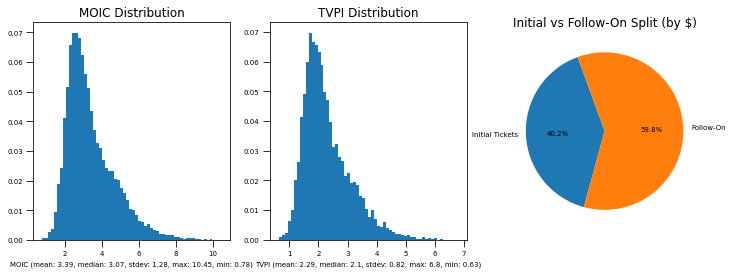

In [ ]:
from simulator_engine import runSimulation, plotStats
from simple_prorata_strategy import SimpleProRataStrategy
from plot_stats import plot_stats_notebook

fp = setFundParameters()
psp = setPortfolioSelectionParameters()
s = setStrategyParameters(SimpleProRataStrategy(fp, psp))

num_iterations = 10000
moics, tvpis, outcomes, [it, ft] = runSimulation(s, num_iterations)

# plot fund performance summary
plot_stats_notebook(moics, tvpis, outcomes, [it, ft])

If you've run with the default parameters set above, then you should see a familiar looking power law distribution, which is not surprising.

# Simulating different number of portfolio companies per fund

More recently, we've seen some discussion about how funds should always maximize the number of portfolio companies in their fund to increase the likelihood of having more outliers in the portfolio and hence increase potential outcomes.

Let's set up a simulation sweep starting with a fund construction of `10` to `130` startups per fund and run each simulation `1000` iterations to generate a decent distribution. Here's the code to do that below...

Portfolio size: 130 |██████████████████████████████████████████████████| 100.00% 



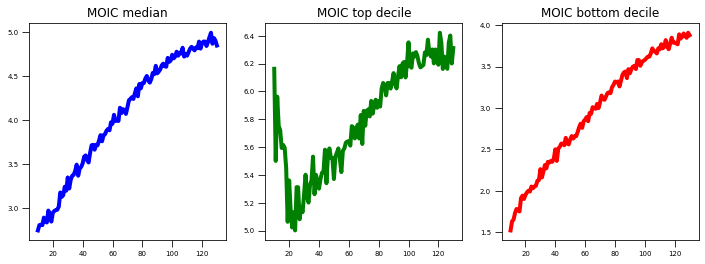

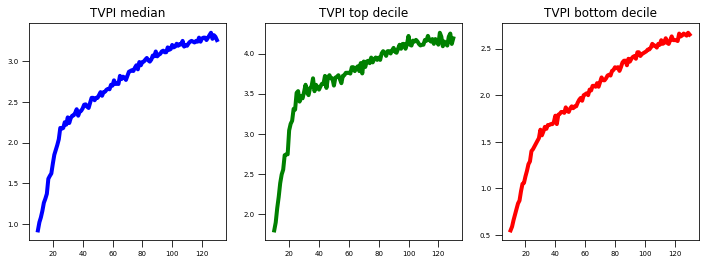

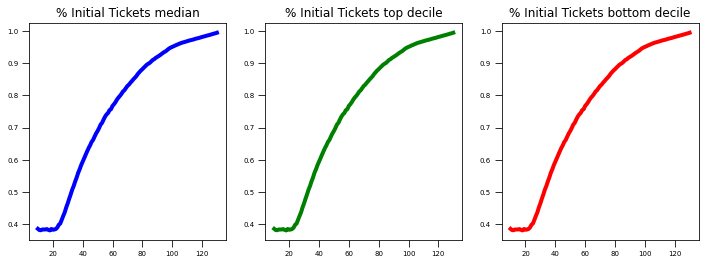

In [ ]:
import numpy
from plot_stats import plot_sweep_stats
from simulator_engine import showProgressBar

moic_stats = {"median": [], "bottom": [], "top": []}
tvpi_stats = {"median": [], "bottom": [], "top": []}
it_stats = {"median": [], "bottom": [], "top": []}

fp = setFundParameters()
psp = setPortfolioSelectionParameters()
s = setStrategyParameters(SimpleProRataStrategy(fp, psp))

num_iterations = 1000
min_portcos = 10
max_portcos = 130
r = range(min_portcos, max_portcos+1)

for i in r:
    
    showProgressBar(i - min_portcos + 1, 
                    max_portcos - min_portcos + 1, 
                    prefix="Portfolio size: " + str(i))
    
    s.setNumPortCos(i)
    moics, tvpis, outcomes, [it, ft] = runSimulation(s, num_iterations, show_progress=False)
    # print("avg initial ticket:",round(it/i/num_iterations), "avg follow on:", round(ft/i/num_iterations), end=" ")
    # print("avg total ticket:",round((it+ft)/num_iterations))

    moic_stats["median"].append(numpy.percentile(moics, 50))
    moic_stats["bottom"].append(numpy.percentile(moics, 10))
    moic_stats["top"].append(numpy.percentile(moics, 90))

    tvpi_stats["median"].append(numpy.percentile(tvpis, 50))
    tvpi_stats["bottom"].append(numpy.percentile(tvpis, 10))
    tvpi_stats["top"].append(numpy.percentile(tvpis, 90))

    it_stats["median"].append(numpy.percentile(1.0*it/(it+ft), 50))
    it_stats["bottom"].append(numpy.percentile(1.0*it/(it+ft), 10))
    it_stats["top"].append(numpy.percentile(1.0*it/(it+ft), 90))


plot_sweep_stats(list(r), moic_stats, "MOIC")
plot_sweep_stats(list(r), tvpi_stats, "TVPI")
plot_sweep_stats(list(r), it_stats, "% Initial Tickets")


Again, not a surprising outcome in general with maybe one exception. 

With fund constructions having sufficiently low number of companies in them, the upper decile MOICs seems to increase drastically while also seeing a lower bottom decile. At first glance this seems odd, but let's think through this...

With a low enough portfolio count, the fund risk increases drastically and we have a large standard deviation of possible outcomes over many simulations. This means that the highs are really high, and the lows are also quite low.  This directionally makes sense.

# What this simulation will NOT tell you

* Increasing portfolio count for the sake of simply increasing the count comes at a cost. For a fund manager who is "sufficiently" skilled by default, this means lowering the bar and therefore the distribution of selection skill parameters configured previously are likely to change (for the worse). By how much? 🤷


* Without thinking very hard about your value-added, your value proposition to founders is likely to drop drastically if you jump from a 25-company to 150-company portfolio fund. For the case of the 100m fund size in our example, investing in 130 portfolio companies translates to a single $600k ticket with materiall no follow-on (initial tickets % of fund deployment approaches 100%). At one point this becomes small enough that there's no real differentiation between your institutional VC fund and angel syndicates. Will founders want to take your ticket vs others? 🤷

### Bottom line:

Having a nice mathematical simulation might help you find some theoretical local optima here and there, but is unlikely to tell you about other on-ground realities of your investment approach. Never forget the ground realities: Your value proposition, founder dynamics, and VC competition for deals